# Phần 1: Thư viện

- **re**: Xử lý chuỗi với các biểu thức chính quy
- **demoji**: Biểu tượng cảm xúc
- **pickle**: Lưu trữ và truy xuất dữ liệu
- **numpy**: Tính toán 
- **pandas**: Cấu trúc dữ liệu và công cụ phân tích dữ liệu 
- **matplotlib.pyplot**: Biểu đồ trong Python
- **tensorflow**: Xây dựng và huấn luyện mô hình học máy
- **scikit-learn**: Các công cụ cho việc học máy và thống kê
- **pyvi**: Thư viện tiếng Việt hóa văn bản

In [1]:
import re
import demoji
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pyvi import ViTokenizer, ViUtils
from underthesea import word_tokenize, text_normalize

demoji.download_codes()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13452\22068759.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


# Phần 2: Xử lý dữ liệu

Nhập liệu

In [2]:
data = pd.read_csv('data_modified.csv')
missing_values = data.isnull().sum()


print(f"Số lượng hàng: {data.shape[0]}")
print(f"Số lượng cột: {data.shape[1]}")
print(f"Tên cột: {list(data.columns)}")
print(f"Thông tin cột bị thiếu: \n{missing_values}")
data.info()

sentiment_data = data
sentiment_data.head(5)

Số lượng hàng: 31460
Số lượng cột: 2
Tên cột: ['comment', 'label']
Thông tin cột bị thiếu: 
comment    0
label      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31460 entries, 0 to 31459
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  31460 non-null  object
 1   label    31460 non-null  object
dtypes: object(2)
memory usage: 491.7+ KB


,comment,label
0,Áo bao đẹp ạ!!,POS
1,Tuyệt vời !,POS
2,2day ao khong giong trong.,NEG
3,"Mùi thơm,bôi lên da mềm da.",POS
4,"Vải đẹp, dày dặn.",POS


Tiền xử lý 

In [3]:
def remove_emo(text):
    emo = demoji.replace(text, '')
    return emo

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_mentions_and_emails(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    return text

In [5]:
input_data = sentiment_data['comment'].values
input_label = sentiment_data['label'].values

label_dict = {'NEG':0,'NEU':1,'POS':2}

input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
    #Chuyển đổi thành list
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    # Chuyển danh sách từ 1 chuỗi
    input_text_pre = " ".join(input_text_pre)

    # Tiền xử lý dữ liệu
    input_text_pre = remove_emo(input_text_pre)  
    input_text_pre = remove_urls(input_text_pre)  
    input_text_pre = remove_mentions_and_emails(input_text_pre)

    # Tách dấu
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))

    # Tách từ
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)

    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])
input_pre

['áo bao đẹp ạ',
 'ao bao dep a',
 'tuyệt_vời',
 'tuyet voi',
 '2day ao khong giong trong',
 '2day ao khong giong trong',
 'mùi thơm bôi lên da mềm da',
 'mui thom boi len da mem da',
 'vải đẹp dày_dặn',
 'vai dep day dan',
 'hàng rất đẹp rất chi là ưng_ý',
 'hang rat dep rat chi la_ung y',
 'chất_lượng sản_phẩm tốt date dài',
 'chat luong san pham tot date dai',
 'ăn_nói và thái_độ phục_vụ tốt',
 'an noi va thai do phuc vu tot',
 'đóng_gói sản_phẩm chắc_chắn',
 'dong goi san pham chac chan',
 'tất sờn hết ca chưa dùng mà vay r',
 'tat son het ca chua dung ma vay r',
 'shop phục_vụ rất tốt',
 'shop phuc vu rat tot',
 'mặc thì cũng đc',
 'mac thi cung dc',
 'chất vải khỏi chê',
 'chat vai khoi che',
 'thời_gian giao hàng rất nhanh',
 'thoi gian giao hang rat nhanh',
 'chất_lượng sản_phẩm tuyệt_vời',
 'chat luong san pham tuyet voi',
 'vải hơi thô cứng thời_gian giao hàng nhanh',
 'vai hoi tho cung thoi gian giao hang_nhanh',
 'chất_lượng sp chưa thật_sự đẹp nhe shop',
 'chat luong sp ch

Biểu đồ histogram dữ liệu từ 0 đến 31k

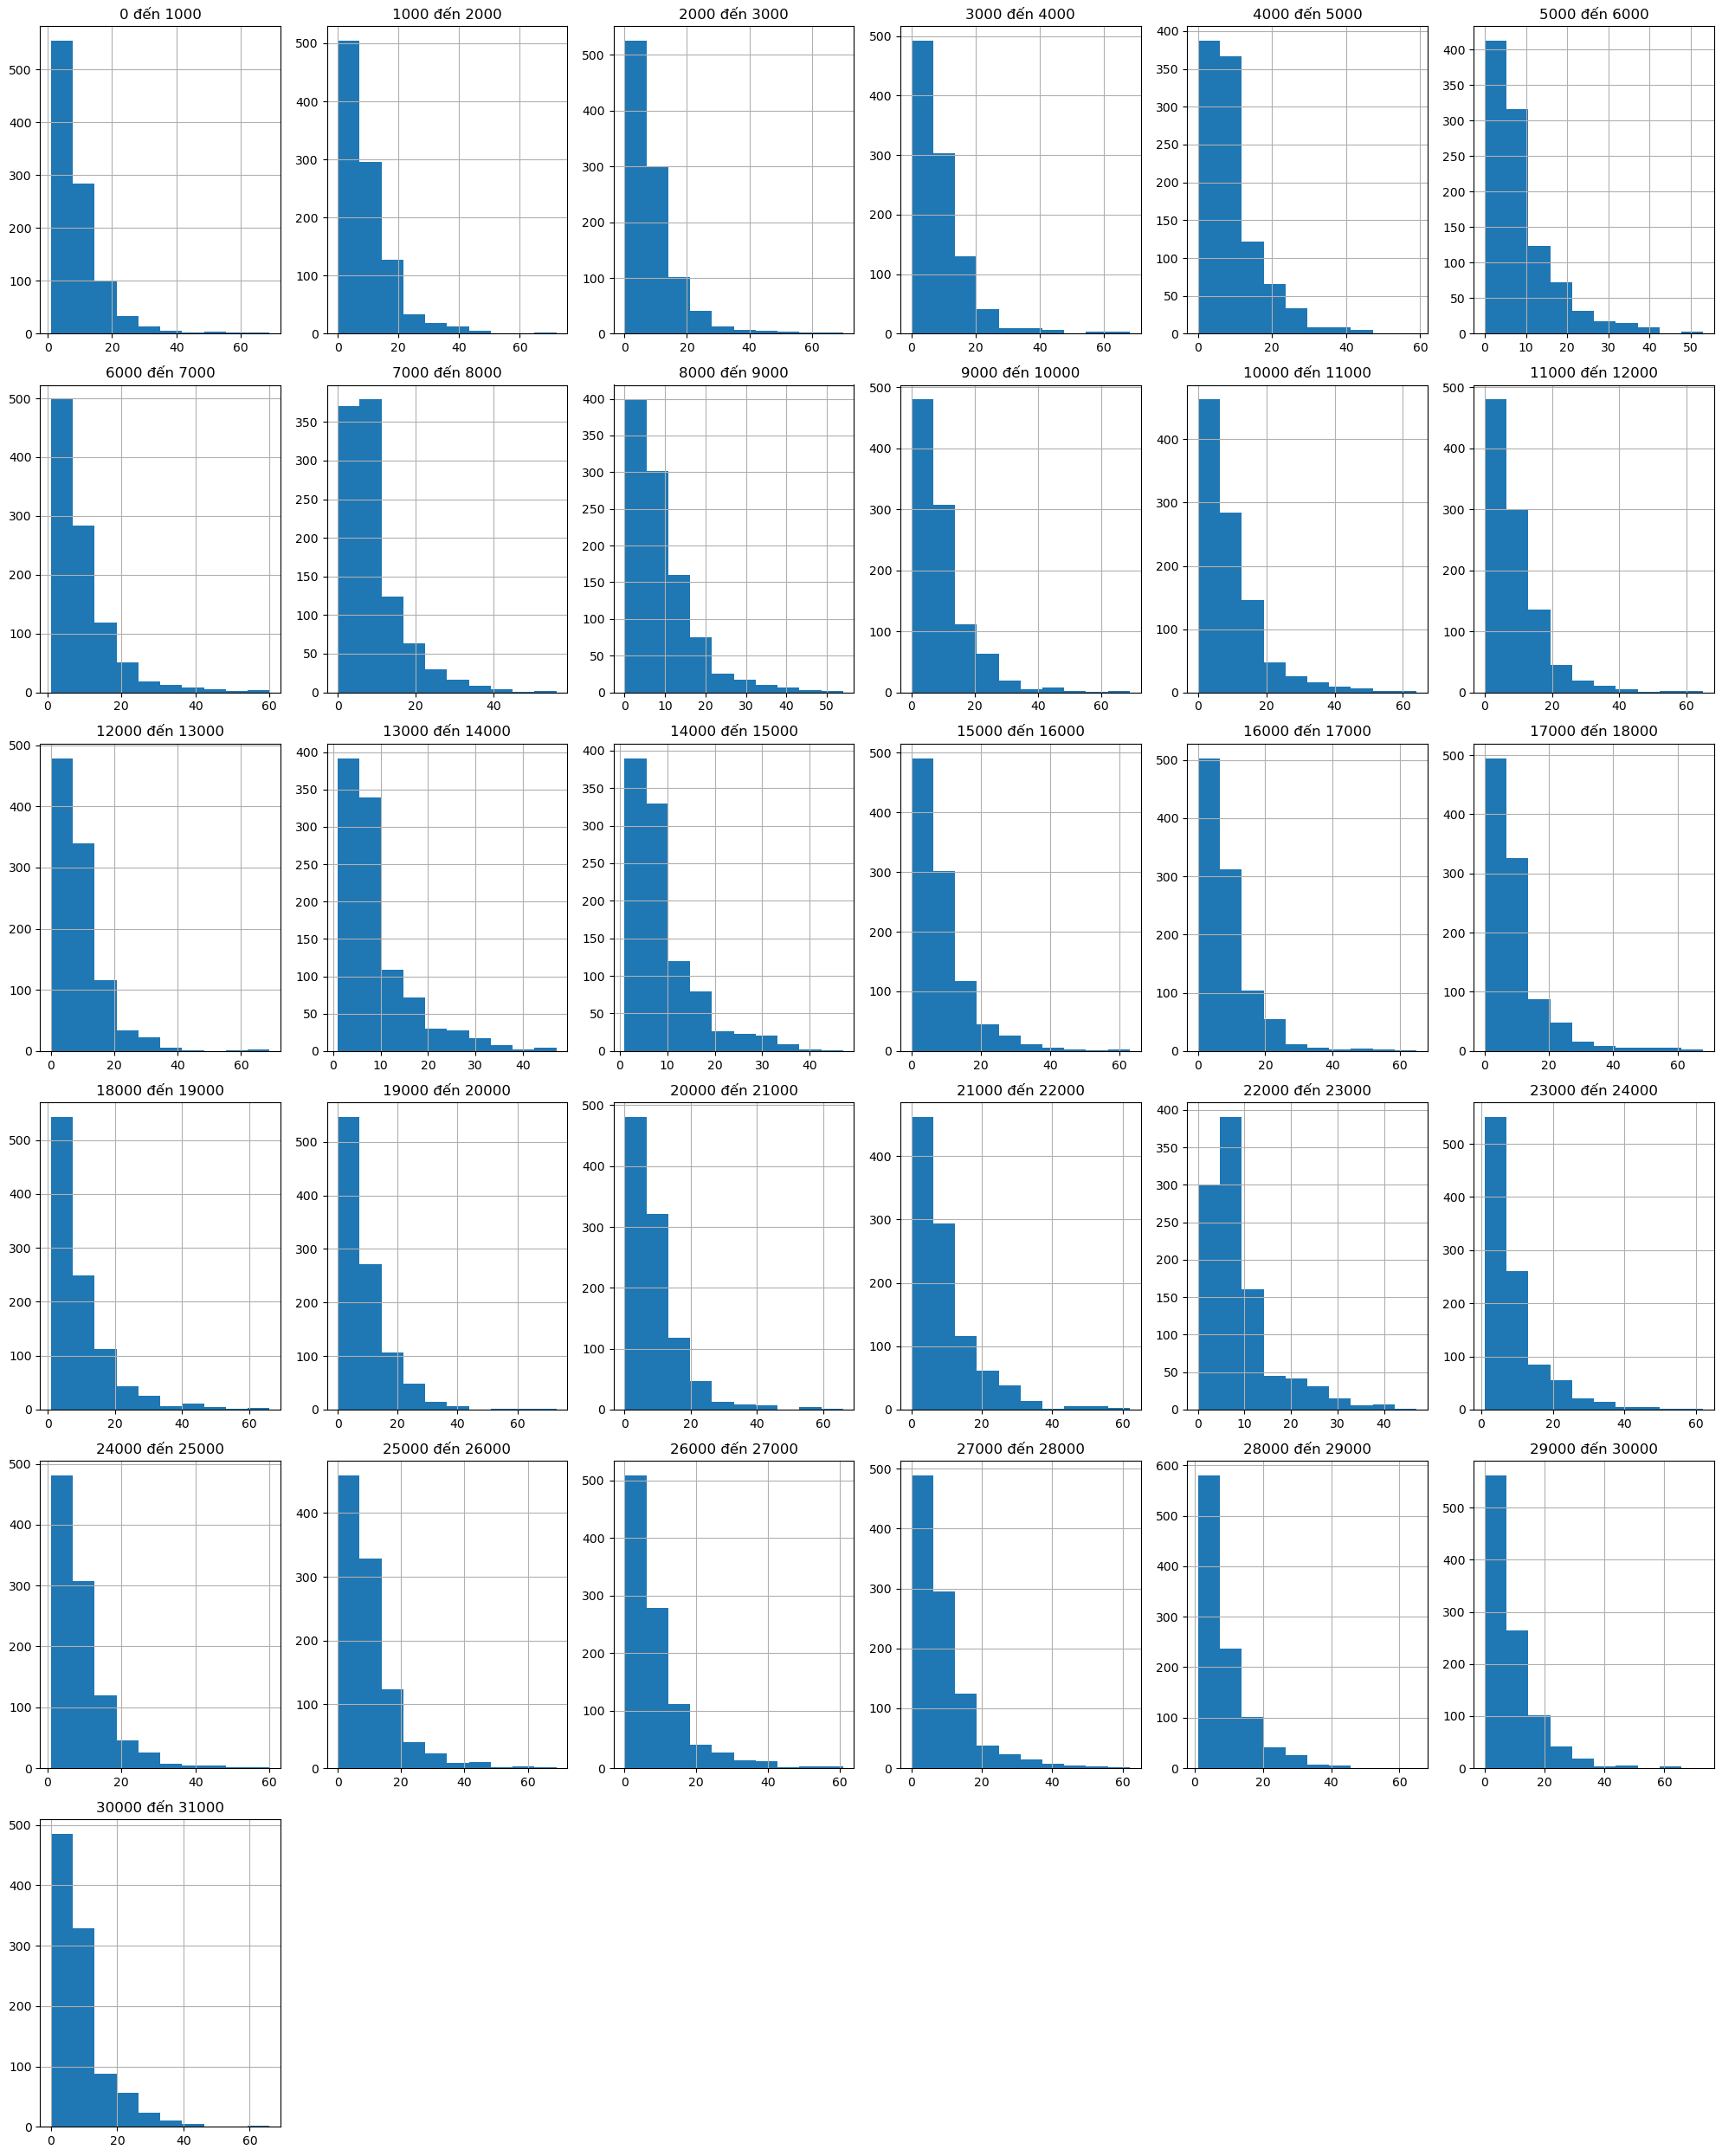

In [6]:
bin_count = 10  # Số lượng bin
chunk_size = 1000   # Kích thước của mỗi phân đoạn
total_chunks = 31000 // chunk_size      # Tổng số phân đoạn

fig, axes = plt.subplots(nrows=(total_chunks // 6) + (1 if total_chunks % 6 != 0 else 0), ncols=6, figsize=(20, (total_chunks // 6) * 5))

for i, ax in zip(range(0, 31000, chunk_size), axes.flatten()):
    seq_len = [len(sentence.split()) for sentence in input_pre[i:i+chunk_size]]     # Tính độ dài của từng câu
    pd.Series(seq_len).hist(bins=bin_count, ax=ax)      # Vẽ histogram
    ax.set_title(f'{i} đến {i+chunk_size}')     # Tiêu đề

for j in range(total_chunks, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [7]:
# chuyển đổi các nhãn từ dạng chuỗi sang dạng số
label_idx = [label_dict[i] for i in label_with_accent]
# mã hóa one-hot
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3)
label_tf = label_tf.astype('float32')

# xử lý văn bản thành các chuỗi số và đệm
tokenizer_data = Tokenizer(oov_token='<OOV>', filters='', split=' ')    # tạo từu khóa OOV, không lọc ký tự cách từ = dấu cách
tokenizer_data.fit_on_texts(input_pre)  # học từ điển từ danh sách đã tiền xử lý
 
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)      # vb => chuỗi số
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=512) # đệm chuỗi số sang dạng cố định 512

#lưu tokenizer
pickle.dump(tokenizer_data, open("tokenizer_data.pkl","wb"))

print(f"Kích thước dữ liệu đầu vào: {vec_data.shape}")
data_vocab_size = len(tokenizer_data.word_index)+1  # kích thước từ điển + từ khóa OOV
print(f"Kích thước của từ điển: {data_vocab_size}")

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Số mẫu trong tập huấn luyện: {len(X_train)}")
print(f"Số mẫu trong tập validation: {len(X_val)}")
print(f"Số mẫu trong tập kiểm tra: {len(X_test)}")


Kích thước dữ liệu đầu vào: (62920, 512)
Kích thước của từ điển: 9777
Số mẫu trong tập huấn luyện: 45302
Số mẫu trong tập validation: 12584
Số mẫu trong tập kiểm tra: 5034


# Phần 3: Train model

In [8]:
def generate_model():
    dropout_threshold = 0.5     # Ngưỡng dropout
    input_dim = data_vocab_size     # Kích thước từ vựng
    output_dim = 32     # Kích thước của vector embedding
    input_length = 512  # Độ dài tối đa
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    # chuyển đổi từ khóa vào vector
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer)(input_layer)

    # CNN để trích xuất đặc trưng
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # Mạng Bi-directional LSTM để xử lý tuần tự dữ liệu
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Kết hợp đặc trưng từ CNN và Bi-LSTM
    combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Các lớp Dense (MLP) để phân loại
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(10, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)     # Lớp đầu ra với 3 lớp, dùng softmax để phân loại

    # Tạo mô hình Keras
    model = Model(inputs=input_layer, outputs=classifier)

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)       # Trình tối ưu Adam với learning rate 0.001
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])        # Hàm mất mát categorical crossentropy và metric accuracy
model.summary()

E:\Software\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 512)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 512, 32)           │         312,864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 512, 32)           │           3,104 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 256, 32)           │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 32)           │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 512, 64)           │          16,640 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 256, 32)           │           3,104 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 256, 64)           │               0 │ bidirectional[0][0]        │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 128, 32)           │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 256, 64)           │          24,832 │ max_pooling1d_2[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 128, 32)           │              64 │ max_pooling1d_1[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_3               │ (None, 128, 64)           │               0 │ bidirectional_1[0][0]      │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 32)           │               0 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 128, 64)           │             128 │ max_pooling1d_3[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 381,451 (1.46 MB)

 Trainable params: 381,451 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Huấn luyện

In [8]:
# Định nghĩa callback để lưu mô hình
callback_model = tf.keras.callbacks.ModelCheckpoint(
    'model_cnn_bilstm.keras',
    monitor='val_loss',
    save_best_only=True  # Chỉ lưu mô hình tốt nhất
)

# Huấn luyện mô hình
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[callback_model]
)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 267s 737ms/step - accuracy: 0.6089 - loss: 0.9224 - val_accuracy: 0.7469 - val_loss: 0.6186
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 268s 757ms/step - accuracy: 0.7384 - loss: 0.6532 - val_accuracy: 0.7794 - val_loss: 0.5586
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 313s 885ms/step - accuracy: 0.7716 - loss: 0.5998 - val_accuracy: 0.7807 - val_loss: 0.5640
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 261s 736ms/step - accuracy: 0.7856 - loss: 0.5664 - val_accuracy: 0.7886 - val_loss: 0.5397
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 286s 808ms/step - accuracy: 0.7904 - loss: 0.5429 - val_accuracy: 0.7864 - val_loss: 0.5374
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 273s 772ms/step - accuracy: 0.7938 - loss: 0.5297 - val_accuracy: 0.7902 - val_loss: 0.5368
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 279s 787ms/step - accuracy: 0.8013 - loss: 0.5086 - val_accuracy: 0.7893 - val_loss: 0.5409
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 275s 777ms/step - accuracy: 0.8038 -

In [9]:
model.load_weights("model_cnn_bilstm.keras")
model.evaluate(X_test,y_test)

158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7864 - loss: 0.5222


[0.5268033742904663, 0.7872467041015625]

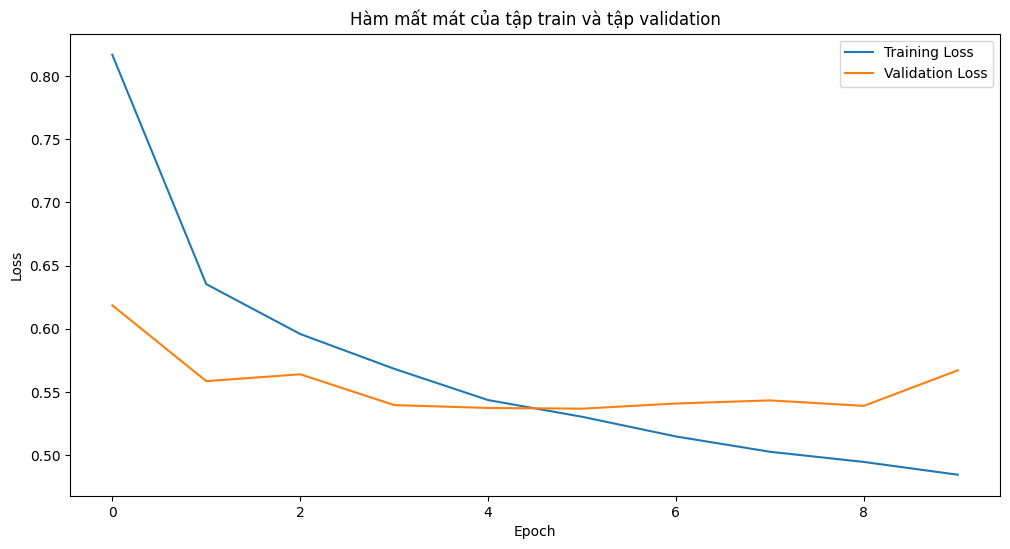

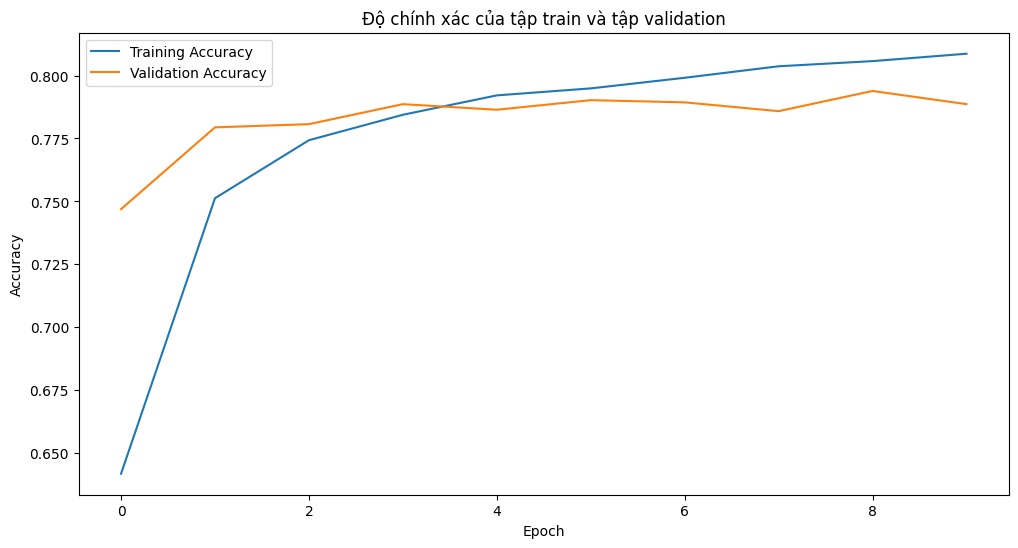

In [10]:
# Trực quan hóa hàm mất mát
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Hàm mất mát của tập train và tập validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Trực quan hóa độ chính xác
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Độ chính xác của tập train và tập validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Phần 4: Chạy Model

In [10]:
# Hàm tiền xử lý đầu vào văn bản th
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = word_tokenize(raw_input, format="text")
    
    # Sửa lỗi chính tả tiếng Việt
    input_text_pre = text_normalize(input_text_pre)
    input_text_pre = remove_emo(input_text_pre)  
    input_text_pre = remove_urls(input_text_pre)  
    input_text_pre = remove_mentions_and_emails(input_text_pre)


    # Đọc danh sách từ viết tắt từ file txt
    abbreviations = {}
    with open('tuviettat.txt', 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip():  # Only process non-empty lines
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    abbreviations[parts[0].strip()] = parts[1].strip()
    # Kiểm tra và thay thế từ viết tắt trong câu
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    words = input_text_pre_accent.split()
    corrected_words = []
    for word in words:
        if word in abbreviations:
            corrected_words.append(abbreviations[word])
        else:
            corrected_words.append(word)
    input_text_pre = " ".join(corrected_words)


    def load_words_to_remove(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            words = file.read().splitlines()
        return words
    words_to_remove = load_words_to_remove('vn_offensive_words_other_formats.txt')
    words = input_text_pre.split()
    words_filtered = [word for word in words if word not in words_to_remove]
    input_text_pre = " ".join(words_filtered)


    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print(f"Comment: {input_text_pre_accent}")
    tokenizer_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=512)
    return vec_data

# Hàm này nhận đầu vào đã tiền xử lý và mô hình để thực hiện suy diễn và trả về kết quả dự đoán
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]    # Dự đoán bằng mô hình
    result = output.argmax()        # Lấy nhãn có xác suất cao nhất
    conf = float(output.max())  
    label_dict = {'NEG': 0, 'NEU': 1, 'POS': 2}         # Từ điển các nhãn
    label = list(label_dict.keys())
    return label[int(result)], conf, model(input_feature).numpy()

# Hàm  kết hợp tiền xử lý và suy diễn 
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)        # Tiền xử lý đầu vào
    # Dự đoán kết quả
    result, conf, out = inference_model(input_model, model)
    return result, conf, out

# Tạo và tải mô hình
my_model = generate_model()
my_model = load_model('model_cnn_bilstm.keras')

# Tải tokenizer từ file
with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)


raw = "dm hàng này ko ônr tý nào cả"
result, con, out = prediction(raw, my_tokenizer, my_model)
print(result, con, out)

Comment: dm hàng này ko ônr_tý nào cả
NEG 0.7118672728538513 [[0.7118673  0.22424419 0.06388864]]


In [12]:
# Hàm để phân loại các bình luận từ file CSV
def classify_comments_from_csv(file_path, tokenizer, model):
    df = pd.read_csv(file_path)
    comments = df.iloc[:, 0]
    
    results = []
    for comment in comments:
        result, conf = prediction(comment, tokenizer, model)
        results.append((comment, result, conf))
    
    result_df = pd.DataFrame(results, columns=['comment', 'label', 'confidence'])
    return result_df

In [24]:
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from PIL import Image, ImageTk
import pandas as pd

history_list = []

def on_predict():
    user_input = input_text.get("1.0", tk.END).strip()
    if user_input:
        result, confidence = prediction(user_input, my_tokenizer, my_model)
        result_label.config(text=f"Kết quả bình luận: {result}, Độ tin cậy: {confidence}")
        save_history(user_input, result)

def save_history(comment, result):
    history_list.append((comment, result))

def delete_history():
    global history_list
    history_list = []
    show_history()

def export_history():
    if not history_list:
        return
    file_path = filedialog.asksaveasfilename(defaultextension='', filetypes=[('CSV files', '*.csv'), ('Text files', '*.txt'), ('Excel files', '*.xlsx')])
    if file_path:
        df = pd.DataFrame(history_list, columns=['Bình luận', 'Kết quả'])
        if file_path.endswith('.csv'):
            df.to_csv(file_path, index=False)
        elif file_path.endswith('.txt'):
            df.to_csv(file_path, index=False, sep=',')
        elif file_path.endswith('.xlsx'):
            df.to_excel(file_path, index=False)
        else:
            tk.messagebox.showerror('Lỗi', 'Định dạng tệp không được hỗ trợ')
            return
        tk.messagebox.showinfo('Lưu thành công', f'Dữ liệu đã được lưu vào {file_path}')

def show_history():
    history_window = tk.Toplevel(root)
    history_window.title("Lịch sử")
    history_window.geometry("280x350")
    history_window.resizable(width=False, height=False)
    
    if not history_list:
        ttk.Label(history_window, text="Chưa có dữ liệu lịch sử.").pack(padx=10, pady=10)
    else:
        frame_P = ttk.Frame(history_window, borderwidth=3, relief="solid", width=280, height=280)
        frame_P.pack(side='top', pady=5)
        frame_P.pack_propagate(False)
        frame_tree = ttk.Frame(frame_P, borderwidth=3, relief="flat", width=280, height=256)
        frame_tree.pack(side='top')
        frame_tree.pack_propagate(False)
        tree_frame = ttk.Frame(frame_tree, borderwidth=0, relief="flat", width=250, height=256)
        tree_frame.pack(side="left", expand=True)
        tree_frame.pack_propagate(False)
        text_widget = tk.Text(tree_frame, wrap='word', width=42, height=17)
        text_widget.pack(side='top',expand=True)
        scrollbar_y = tk.Scrollbar(frame_tree, orient="vertical")
        scrollbar_y.pack(side="right", fill="y")
        scrollbar_x = tk.Scrollbar(frame_P, orient="horizontal")
        scrollbar_x.pack(side="top", fill="x")
        text_widget.configure(yscrollcommand=scrollbar_y.set)
        text_widget.configure(xscrollcommand=scrollbar_x.set)
        for i, (comment, result) in enumerate(history_list, start=1):
            text_widget.insert('end', f"Bình luận {i}: {comment}\nKết quả: {result}\n\n")

        text_widget.config(state='disabled')

    frame_history = ttk.Frame(history_window, borderwidth=0, relief="solid", width=380, height=50)
    frame_history.pack(side='top')
    frame_history.pack_propagate(False)
    ttk.Button(frame_history, text="Xóa lịch sử", command=delete_history).pack(side='left', ipadx=10, ipady=5, fill='both', expand=True)
    ttk.Button(frame_history, text="Lưu lịch sử", command=export_history).pack(side='left', ipadx=10, ipady=5, fill='both', expand=True)

# Hàm để tải file CSV
def upload_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if file_path:
        global result_df
        try:
            result_df = classify_comments_from_csv(file_path, my_tokenizer, my_model)
            label_configure.config(text="File đã được tải lên")
        except Exception as e:
            tk.messagebox.showerror("Lỗi 404", f"Không thể xử lý tệp: {e}")
            label_configure.config(text="Vui lòng tải lại.")
    else:
        label_configure.config(text="Không có tệp được chọn.")

# Hàm để xuất file CSV
def export_file():
    if 'result_df' in globals():
        file_path = filedialog.asksaveasfilename(defaultextension=".csv", 
                                                 filetypes=[("CSV Files", "*.csv"), 
                                                            ("Text Files", "*.txt"), 
                                                            ("Excel Files", "*.xlsx")])
        if file_path:
            try:
                if file_path.endswith('.csv'):
                    result_df.to_csv(file_path, index=False)
                elif file_path.endswith('.txt'):
                    result_df.to_csv(file_path, sep=',', index=False)
                elif file_path.endswith('.xlsx'):
                    result_df.to_excel(file_path, index=False)
                label_configure.config(text="Lưu tệp thành công")
            except Exception as e:
                tk.messagebox.showerror("Lỗi 400", f"Không thể xuất tệp: {e}")
                label_configure.config(text="Vui lòng thử lại")
    else:
        tk.messagebox.showwarning("Warning", "Không có kết quả để xuất. Vui lòng tải lên và xử lý tệp trước.")
        label_configure.config(text="Vui lòng tải lên và xử lý tệp trước.")

# Hàm xóa nội dung văn bản
def clear_text():
    input_text.delete("1.0", tk.END)
    result_label.config(text="")


# Tạo cửa sổ chính
root = tk.Tk()
root.title("Phân tích cảm xúc bằng văn bản")
root.iconbitmap("img/Logo.ico")
root.geometry("600x450")
root.configure(bg="#f0f0f0")
root.resizable(width=False, height=False)


#-----------------------------------------------------------------------------------------------------------------------------------
frame_P1 = ttk.Frame(root, borderwidth=0, relief="flat", width=380, height=50)
frame_P1.pack(side='top')
frame_P1.pack_propagate(False)

# Tiêu đề
title_label = ttk.Label(frame_P1, text="Phân tích cảm xúc bằng văn bản", font=("Helvetica", 16))
title_label.pack(side='left', padx=5, pady=10)

gifImage = "img/decorate_duck.gif"
openImage = Image.open(gifImage)

new_width = 50
new_height = 55
imageObject = []
for frame_num in range(openImage.n_frames):
    openImage.seek(frame_num)
    resized_frame = openImage.resize((new_width, new_height), Image.Resampling.LANCZOS)
    imageObject.append(ImageTk.PhotoImage(resized_frame))
count = 0

def animation(count):
    newImage = imageObject[count]
    gif_Label.configure(image=newImage)
    count += 1
    if count == openImage.n_frames:
        count = 0
    frame_P1.after(50, lambda: animation(count))

gif_Label = ttk.Label(frame_P1, image="")
gif_Label.pack(side='left', padx=1, pady=1)
frame_P1.after(50, lambda: animation(count))

#-----------------------------------------------------------------------------------------------------------------------------
frame_P2 = ttk.Frame(root, borderwidth=0, relief="flat", width=600, height=230)
frame_P2.pack(side='top')
frame_P2.pack_propagate(False)

# Hướng dẫn sử dụng
help_frame = ttk.Frame(frame_P2, padding="10", borderwidth=2, relief="solid")
help_frame.pack(padx=10, pady=5, fill="x")

help_label = ttk.Label(help_frame, text="Hướng dẫn:", font=("Helvetica", 14))
help_label.pack(pady=5, anchor='w')

normal_font = ('Helvetica', 10)
help_gt = (
    " \n"
    "- Hãy nhập bất kỳ bình luận nào liên quan đến mua sắm sản phẩm trên các sàn thương mại điện tử.\n"
    "- Hệ thống sẽ phân tích và trả về kết quả theo 3 mức độ cảm xúc: NEG, NEU và POS.\n"
    "  Chi tiết như sau:\n"
    "    ~ NEG: Bình luận mang tính tiêu cực\n"
    "    ~ NEU: Bình luận mang tính trung lập\n"
    "    ~ POS: Bình luận mang tính tích cực\n"
    "* Mức độ chính xác từ khoảng 60% đến 80%"
)

help_gioithieu_content = ttk.Label(help_frame, text=help_gt, font=normal_font, wraplength=550)
help_gioithieu_content.pack(pady=5, anchor='w')

#-------------------------------------------------------------------------------------------------------------------------
frame_P3 = ttk.Frame(root, borderwidth=0, relief="flat", width=600, height=80)
frame_P3.pack(side='top')
frame_P3.pack_propagate(False)

# Nút để bắt đầu phân tích và xóa
text_frame = ttk.Frame(frame_P3,relief="flat", width=450, height=70)
text_frame.pack(side="left", padx=10)
text_frame.pack_propagate(False)

label = ttk.Label(text_frame, text="Nhập văn bản:", font=("Helvetica", 10))
label.pack(side='top', anchor='w', padx=5, pady=5)

# Text box để nhập văn bản
input_text = tk.Text(text_frame, height=1, width=45, font=("Helvetica", 12))
input_text.pack(side="top",padx=10, pady=5)

# Nút để bắt đầu phân tích và xóa
button_frame = ttk.Frame(frame_P3,relief="solid", width=120, height=70)
button_frame.pack(side="right", padx=10)
button_frame.pack_propagate(False)

analyze_button = ttk.Button(button_frame, text="Phân tích cảm xúc", command=on_predict)
analyze_button.pack(side='top', ipadx=10, ipady=5, fill='both', expand=True)

clear_button = ttk.Button(button_frame, text="Xóa", command=clear_text)
clear_button.pack(side='top', ipadx=10, ipady=5, fill='both', expand=True)

#-----------------------------------------------------------------------------------------------------------------------------
frame_P4 = ttk.Frame(root, borderwidth=0, relief="flat", width=580, height=40)
frame_P4.pack(side='top')
frame_P4.pack_propagate(False)

result_label = ttk.Label(frame_P4, text="Kết quả bình luận:", font=("Helvetica", 10), wraplength=550, background="#f0f0f0")
result_label.pack(side='left',padx=10,pady=10)

history_button = ttk.Button(frame_P4, text="Lịch sử", command=show_history)
history_button.pack(side='right',padx=5, ipadx=15, ipady=5)

#--------------------------------------------------------------------------------------------------------------------
frame_P5 = ttk.Frame(root, borderwidth=0, relief="solid", width=580, height=40)
frame_P5.pack(side='top',pady=5)
frame_P5.pack_propagate(False)

frame_button_upload = ttk.Frame(frame_P5, relief="flat", width=320, height=40)
frame_button_upload.pack(side="left", padx=5)
frame_button_upload.pack_propagate(False)

# Tạo nút để tải file CSV
upload_button = ttk.Button(frame_button_upload, text="Upload CSV", command=upload_file)
upload_button.pack(side="left",padx=5,pady=5,fill='both', expand=True)

# Tạo nút để xuất file CSV
export_button = ttk.Button(frame_button_upload, text="Export CSV", command=export_file)
export_button.pack(side="left",padx=5,pady=5, fill='both', expand=True)

label_configure = ttk.Label(frame_P5, text="Tải file chứa bình luận", wraplength=400)
label_configure.pack(side='right',padx=5,pady=10, fill='both', expand=True)

# Chạy ứng dụng
root.mainloop()

Comment: tốt
Comment: tạm ổn
